# Manipulating Layers of ARIA standard GUNW products

**Author**: Robert Zinke - Jet Propulsion Laboratory

This notebook demonstrates phase triplet misclosure calculation using the **`ariaMisclosure.py`** function. In this tutorial, we will introduce the concept of phase misclosure as a means of assessing the quality of an interferogram data set. We will then show how the `ariaMisclosure.py` tool can be used to explore the spatial and temporal patterns of misclosure in a data set.

## Table of Contents

[**What is phase misclosure**](#what_is_phase_misclosure)

[**Misclosure computation**](#misclosure_computation)
- [Loading data](#loading_data)
- [Phase triplet formulation](#phase_triplet_formulation)
- [Reference point](#reference_point)

[**Misclosure analysis**](#misclosure_analysis)
- [Net misclosure and absolute misclosure](#net_misclosure_and_absolute_misclosure)
- [Misclosure visualization](#misclosure_visualization)

## Prep A. Initial setup of the notebook

If you have not already done so, it is recommended that you first check out the [**ariaTSsetup_tutorial**](https://github.com/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaTSsetup/ariaTSsetup_tutorial.ipynb). The `ariaMisclosure.py` routines are designed to work with outputs produced by `ariaTSsetup.py`. Note that completion of ariaTSsetup_tutorial is not required, as this tutorial will use a different, smaller data set.

We first set up the file structure and initial notebook parameters. This step should be run each time this tutorial is (re)opened.

In [1]:
## Import standard modules
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

## Import ARIA-tools modules
from ARIAtools.computeMisclosure import stack

## Define the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verify if ARIA-tools is installed correctly
try:
    import ARIAtools.shapefile_util as shputil
except:
    raise Exception('ARIA-tools is missing from your PYTHONPATH')
        
os.chdir(work_dir)

Work directory:  /Volumes/BB_1TB/ARIA-tools-docs_git/JupyterDocs/ariaMisclosure
Tutorial directory:  /Volumes/BB_1TB/ARIA-tools-docs_git/JupyterDocs/ariaMisclosure


## Prep B. Download and process the data

Next, we download the products using the `ariaDownload.py` function. This will take a few minutes if the products are not already downloaded.

For this tutorial, we will use data from descending track 42 over central California.

<img src="./support_docs/Parkfield_overview.png" alt="track" width="600">

<blockquote>Google Earth image of the creeping section of the San Andreas Fault near Parkfield. Gray boxes are Track 42 acquisitions. White boxes denote are the bounding box of our study area. Faults from USGS Quaternary fault catalog are plotted in background. For interpretation of fault trace colors, refer to see <a> href="https://earthquake.usgs.gov/hazards/qfaults/">USGS fault catalogue website </a>. </blockquote>

In [2]:
!ariaDownload.py -t 42 -b '35.5 37.5 -122 -120' -w products -s 20170701 -e 20180101

https://api.daac.asf.alaska.edu/services/search/param?asfplatform=Sentinel-1%20Interferogram%20(BETA)&processingLevel=GUNW_STD&output=JSON&relativeOrbit=42&bbox=-122,35.5,-120,37.5
 > attempting to download https://urs.earthdata.nasa.gov/profile
 > Re-using previous cookie jar.
 > Download file S1-GUNW-D-R-042-tops-20171227_20171121-140842-35635N_33657N-PP-5a38-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171227_20171121-140842-35635N_33657N-PP-5a38-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20171227_20171203-140842-35635N_33657N-PP-7b97-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171227_20171203-140842-35635N_33657N-PP-7b97-v2_0_0.nc. 
 > Download file S1-GUNW-D-R-042-tops-20171227_20171215-140842-35635N_33657N-PP-f075-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171227_20171215-140842-35635

 > Downloaded 67610425 of 67610425 bytes (100.00%)
Downloaded 67610425b in 5.45secs, Average Rate: 11.84MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171203_20171121-140843-35635N_33658N-PP-1c2e-v2_0_0.nc?userid=bbuzz&Expires=1594782392&Signature=Ddnu9qJlFZqjNyUCydBJDCzlIbB30fKucJFFSolAVWBi5ivCpGLLUrWiAawjyRqtznwvrVjzEUDmcODmFw9-gq~IWZXdkbc65leewLF0ugtjByf7N4Q~5shjjgDaxBp7J4M06QJIpSmsHH3vZ81jjl~7Gj7Dg~m3gnpf4yWz3qY_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(21/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171203_20171121-140843-35635N_33658N-PP-1c2e-v2_0_0.nc
 > Downloaded 65024574 of 65024574 bytes (100.00%)
Downloaded 65024574b in 5.07secs, Average Rate: 12.23MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171203_20171028-140818-37128N_35153N-PP-d66f-v2_0_2.nc?userid=bbuzz&Expires=1594782397&Signature=37j9RTcMrM

 > Downloaded 65780736 of 65780736 bytes (100.00%)
Downloaded 65780736b in 6.36secs, Average Rate: 9.87MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171121_20171016-140754-38620N_36646N-PP-e7d1-v2_0_2.nc?userid=bbuzz&Expires=1594782522&Signature=ybh8r9U-Cq-wlJSXWADdyZl8RPpFASq8Oqbqkn0u3tg4S09H3vsCYX7LMC6jcQLQNp1jPJIIpG3K8FW3-P0NvZ6hj2ZL2xNsx9yr40Tqzxgr9-igNfqZ6--Eh8-z6mSVSyTimNBVJmjvw9u5PVsITHXPs4QFeFpJNYOpKUqy7dA_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(34/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171121_20171016-140754-38620N_36646N-PP-e7d1-v2_0_2.nc
 > Downloaded 64842785 of 64842785 bytes (100.00%)
Downloaded 64842785b in 7.89secs, Average Rate: 7.84MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171121_20171028-140754-38620N_36646N-PP-6e88-v2_0_0.nc?userid=bbuzz&Expires=1594782529&Signature=qMK8dILXMEBF

 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171028_20170910-140844-35635N_33658N-PP-ca62-v2_0_2.nc?userid=bbuzz&Expires=1594783062&Signature=gTaCgWgPxFK3sr2ivaDIm2kjfrR-7PKEEzwH64F~VwqnvVcwwgsr-k7H2N7LEHMw7kVyxe2ZBHEdPuIEFjXfPBqpHXBX16J0q2uNSxklsFHZRbI86UV6i7aBBrm3UWiZFcKu-hz25r12iqR3W3O7Oyt9ybEjqc38QGZ2vzB3ato_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(46/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171028_20170910-140844-35635N_33658N-PP-ca62-v2_0_2.nc
 > Downloaded 65032641 of 65032641 bytes (100.00%)
Downloaded 65032641b in 12.86secs, Average Rate: 4.82MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171028_20171004-140844-35635N_33658N-PP-2392-v2_0_0.nc?userid=bbuzz&Expires=1594783075&Signature=XdWJ0fl9nW5gnVLynWUl4cAiNNKhnTZYarmbRiJk8CHuMq4N8VLNZ0WMa1yXcemAW~KtuW-pvKL2G9NtCFlBe7Xt2zTKkZLNdl43C1di4ymPVeYI-L89O2~NA

 > Downloaded 65282244 of 65282244 bytes (100.00%)
Downloaded 65282244b in 13.58secs, Average Rate: 4.58MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171016_20170910-140819-37127N_35152N-PP-f80f-v2_0_0.nc?userid=bbuzz&Expires=1594783154&Signature=aSxQJNyo4s4vuoy5IfKf-Yhcxq05rQ8u492ml6Nxs7QNzvDQ9tdVqsGJK3QcaZ~5GwRFW4sLHpnyEWjVbHqOs0M7oJZWflp8WOiWNY3WhoDzOjgY4ykCbv6N6~yA5xfvb117WpVRndJyAsHhTeD12F2gWuBfQW4wIS5cMOS7x-8_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(59/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171016_20170910-140819-37127N_35152N-PP-f80f-v2_0_0.nc
 > Downloaded 64952537 of 64952537 bytes (100.00%)
Downloaded 64952537b in 17.88secs, Average Rate: 3.46MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171016_20171004-140819-37127N_35152N-PP-4a7d-v2_0_0.nc?userid=bbuzz&Expires=1594783172&Signature=X-ECovAc2U

 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171004_20170817-140754-38619N_36645N-PP-c996-v2_0_0.nc?userid=bbuzz&Expires=1594783231&Signature=4cPmOwcMk6YzddLOvfGtwLw0J1kwE5FkduDC53dRUzvOjFbw7DRFNyTU~dzrQAqrFKXOnDLfmZ4G6Ao-Zv0gnmTifYoVI6a2M06I4nuXwmLCFF1qSUStekF5qd0nKw650zagizqhMceaq~IgJVivVwEtS7262AB~~7uxx9H1ico_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(71/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171004_20170817-140754-38619N_36645N-PP-c996-v2_0_0.nc
 > Downloaded 63436634 of 63436634 bytes (100.00%)
Downloaded 63436634b in 5.05secs, Average Rate: 11.99MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171004_20170910-140754-38619N_36645N-PP-decc-v2_0_0.nc?userid=bbuzz&Expires=1594783236&Signature=a1CgsKG2UPhfGqg38RUSHCjv2GA5t-Rjgv9eEZTElropsaIaDPQF~bBtbSp63Ch5cjYH6aZfo~pSlR5YAe2HBgTkTiWME4S3XkaCmGeAKhCLf9kYy8Cd43Dbw

 > Downloaded 67375475 of 67375475 bytes (100.00%) 67375475 bytes (52.03%)f 67375475 bytes (54.74%)
Downloaded 67375475b in 6.08secs, Average Rate: 10.57MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170817_20170805-140842-35635N_33658N-PP-bb54-v2_0_0.nc?userid=bbuzz&Expires=1594783310&Signature=whOQIE65azlBhn5zYPgO-Jtj-jSwgAh8ygiAvktWPdUhDF7e9Wa6AGInjk946fMw-PGdRXUKFpKGmoSEEg9DU6HRiV4ckSL-qiPHYariQprtY0sPSeENoS-jgB7YbE92qfUlbWTeDQ7tADHa7q33NZz6UqlJLGcME2Mj~kmP9mk_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(84/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170817_20170805-140842-35635N_33658N-PP-bb54-v2_0_0.nc
 > Downloaded 65463822 of 65463822 bytes (100.00%) 65463822 bytes (55.21%)f 65463822 bytes (58.50%)f 65463822 bytes (71.38%)
Downloaded 65463822b in 6.48secs, Average Rate: 9.63MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-

 > Downloaded 63193297 of 63193297 bytes (100.00%) 63193297 bytes (55.34%)
Downloaded 63193297b in 9.13secs, Average Rate: 6.60MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170805_20170712-140752-38619N_36646N-PP-fa4a-v2_0_0.nc?userid=bbuzz&Expires=1594783422&Signature=BRf~QZmNZs~EsbXzDBjgolDvZfthsb93Qhn1mZigv-qhVx~N46M6MEUixSaOA~snJQ6vDVp73nPpa2SQAIsvd99la4beJhXBwTFoU02JAKmMHSCht0jB5Yh5dMV6CzfH70jVhvSEb7MOYg-8KdvB1qJnSWjiSdK2dbAF0oAivg8_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(95/99) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170805_20170712-140752-38619N_36646N-PP-fa4a-v2_0_0.nc
 > Downloaded 64315297 of 64315297 bytes (100.00%) 64315297 bytes (52.59%)f 64315297 bytes (72.45%)
Downloaded 64315297b in 6.88secs, Average Rate: 8.91MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170805_20170724-140752-38619N_36646N

We next extract the products for timeseries computation using `ariaTSsetup.py`. Extracted products for timeseries setup will go to the TSsetup subfolder.

In [3]:
!ariaTSsetup.py -w TSsetup -f 'products/*.nc' -d download -m download -b '35.5 37.5 -122 -120' -nt 4

***Time-series Preparation Function:***
Shapefile TSsetup/user_bbox.json created for input user bounds.
Multi-core version
All (99) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (33) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 4
Download/cropping DEM
Downloaded 3 arc-sec SRTM DEM here: TSsetup/DEM/SRTM_3arcsec.dem
***Downloading water mask... ***

Extracting unwrapped phase, coherence, and connected components for each interferogram pair
Generating: unwrappedPhase - [===========>            24%                       ] 20170910_20170805  102s /   325sMulti-core version failed, will try single for loop
Generating: unwrappedPhase - [======================= 82% ============>         ] 20171203_20171121  383s /    84sMulti-core version failed, will try single for loop
Generating: unwrappedPhase - [==================================================] 20171227_20171215  463s /   

## What is phase misclosure
<a id= 'what_is_phase_misclosure'></a>

**Phase misclosure** is the disagreement between measurements of differential phase between common epochs *i*, *j*, and *k*. For the triplet of interferograms describing phase change $\Delta\phi_{ij}$, $\Delta\phi_{jk}$, $\Delta\phi_{ik}$, phase misclosure $\omega$ is simply the difference between the expected phase change from the sum $(\Delta\phi_{ij}$ + $\Delta\phi_{jk})$ and the phase difference measured by $\Delta\phi_{ik}$:

<div align = center> $\omega = \Delta\phi_{ij} + \Delta\phi_{jk} - \Delta\phi_{ik}$ <div /align = center>

This can be illustrated graphically with the following diagram.

<img src="./support_docs/PhaseClosure_diagram.png" alt="track" width="600">

<blockquote>Phase triplet misclosure is the disagreement between measurements with different time paths.</blockquote>

## Misclosure computation
<a id = 'misclosure_computation'></a>

Inputs for the `ariaMisclosure.py` function can be shown using the `-h` option. Examples are also shown.

In [4]:
## ariaMisclosure help menu
!ariaMisclosure.py -h

usage: ariaMisclosure.py [-h] -f IMGFILE [-w WORKDIR] [--startdate STARTDATE]
                         [--enddate ENDDATE] [--exclude-pairs EXCLUDEPAIRS]
                         [--plot-pairs] [--mintime MINTIME]
                         [--maxtime MAXTIME] [--print-triplets]
                         [--plot-triplets] [-refX REFX] [-refY REFY]
                         [-refLon REFLON] [-refLat REFLAT] [--queryX QUERYX]
                         [--queryY QUERYY] [--queryLon QUERYLON]
                         [--queryLat QUERYLAT] [-v] [--pctmin PCTMINCLIP]
                         [--pctmax PCTMAXCLIP] [--plot-time-intervals]

Compute the cumulative misclosure of phase triplets based on a set of interferograms
saved in the stack/unwrapStack.vrt data set. During triplet computation, values at a reference point
are removed from the interferograms prior to misclosure computation to account for abiguities in the
unwrapped phase that might arise during pairwise computation.

The code works 

### Loading data
<a id = 'loading_data'></a>

The `ariaMisclosure.py` function requires the "stack" file generated by `ariaTSsetup.py`. The "stack/unwrapStack.vrt" file contains links (.VRT) to all the stitched, unwrapped interferograms.

Through the command line interface, call the function using:

`ariaMisclosure.py -f stack/unwrapStack.vrt`


<div class="alert alert-warning">
Although the ariaMisclosure.py function only requires the filename (-f unwrapStack.vrt), the resulting analyses depend greatly on the selection of triplets evaluated, and the reference point chosen. Triplet definitions and selection are discussed in detail in the <b>Phase triplet formulation</b> section below. Reference point selection is described in the <b>Reference point</b> section.
</div>

Below, we instantiate the underlying class directly for demonstration purposes.

In [5]:
## Load data using "stack" object
dataStack = stack('TSsetup/stack/unwrapStack.vrt')

# [print(pair[0].strftime('%Y%m%d')+'_'+pair[1].strftime('%Y%m%d')) for pair in dataStack.pairs];
# [print((pair[0]-pair[1]).days) for pair in dataStack.pairs];

### Available pairs

As we will see below, the available triplet combinations depend on the available pairs. For an intuitive overview of the pairing strategy, invoke the `--plot-pairs` option.

This can be done using:
`ariaMisclosure.py -f stack/unwrapStack.vrt --plot-pairs`

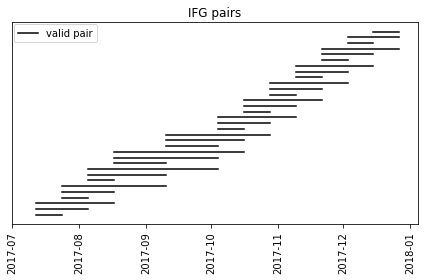

In [6]:
## Plot pairs
dataStack.plotPairs()

In the figure above, the pairs are ordered by secondary date. Note how the pair intervals range from 12 days to 60 days, in increments of 12 days (12, 24, 36, 48, 60).

### Phase triplet formulation
<a id = 'phase_triplet_formulation'></a>

Misclosure computation depends on the selection of epochs that constitute the "triplet" of interferograms. For instance, selection of pairs with 6- and 12-day lags...

e.g., for dates *i* 20150101, *j* 20150107, and *k* 20150114

20150107_20150101 ( *j i* = 6 days)

20150113_20150107 ( *k j* = 6 days)

20150113_20150101 ( *k i* = 12 days)

... will lead to a different result than pairs with 12- and 24-day lags...

e.g., for dates *i* 20150101, *j* 20150113, and *k* 20150125

20150113_20150101 ( *j i* = 12 days)

20150125_20150113 ( *k j* = 12 days)

20150125_20150101 ( *k i* = 24 days)


### Triplet selection

It is left to the user to define the triplet strategy of choice, keeping in mind what pairs are available in the data set.

By default, `ariaMisclosure.py` will create a list of all possible triplets based on the dates provided. To view a list of all possible triplets, invoke the `--print-triplets` flag:

`ariaMisclosure.py -f stack/unwrapStack.vrt --print-triplets`

For a schematic of the triplets, use `--plot-triplets`:

`ariaMisclosure.py -f stack/unwrapStack.vrt --plot-triplets`

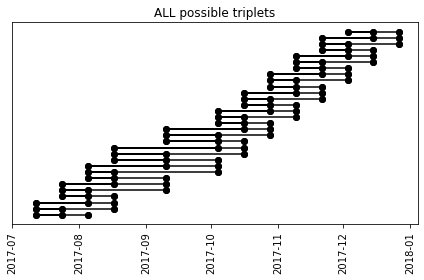

In [7]:
## Create list of all possible triplets:
#    `ariaMisclosure.py -f stack/unwrapStack.vrt --plot-triplets`
dataStack.createTriplets()

## Plot triplet schematic
dataStack.plotTriplets()
plt.gca().set_title('ALL possible triplets');

To reduce the list to include only pairs and triplets of interest, `ariaMisclosure.py` provides several inputs options for the user.

For example, let's say that we only want to use pairs with 12-day and 24-day intervals. Use the `--maxtime` option to specify the maximum allowable time interval:

`ariaMisclosure.py -f stack/unwrapStack.vrt --plot-triplets --mintime 12 --maxtime 24`

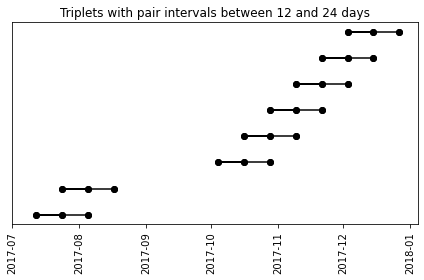

In [8]:
## Limit triplets to 12-24 days
dataStack.createTriplets(minTime=12,maxTime=24)

## Plot triplet schematic
dataStack.plotTriplets()
plt.gca().set_title('Triplets with pair intervals between 12 and 24 days');


These criteria result in perfectly symmetric pair durations for each triplet, but perhaps the selection criteria are too stringent, resulting in gaps. If we include 36-day pairs, broader temporal coverage is available.

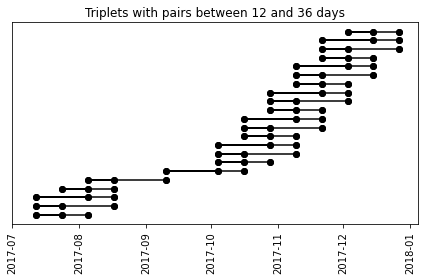

In [9]:
## Limit triplets to 12-36 days
dataStack.createTriplets(minTime=12,maxTime=36)

## Plot triplets
dataStack.plotTriplets()
plt.gca().set_title('Triplets with pairs between 12 and 36 days');

Note that this strategy, however, gives more than one triplet for a given start date. Interpretation of the results can be complicated in this case, so for this demonstration we will return to our maximum time limit of 24 days.

In [10]:
## Reformulate triplets
dataStack.createTriplets(minTime=12,maxTime=24)

### Reference point
<a id = "reference_point"></a>

The interferograms generated through the ARIA workflow are processed in a pair-wise manner. That is, each secondary image is registered to its respective master; interferograms are not coregistered in a stack to a single master. A reference point in space is therefore necesary to align the interferograms such that their phases are meaningful, much in the same way that a spatial reference point is necessary for timeseries computation.

`ariaMisclosure.py` offsers several options for selecting the reference point:

- Automatic
- XY pixel specification
- Lon/Lat specification

By default, `ariaMisclosure.py` will automatically select a random reference point at a pixel with high average filtered coherence. Specifically, the routines call the filtered coherence maps from stack/cohStack.vrt. These maps are summed to find pixels with average coherence > 0.7, from which a random location is chosen. This can be used as a first pass approach, but it is strongly recommended that the user identify an optimal location and define the reference point manually.

Here, we use the reference point -120.96$^\circ$E, 36.61$^\circ$N, which is in an unfarmed field away from steep topography or major tectonic structures. The command for this is:

`ariaMisclosure.py -f stack/unwrapStack.vrt --mintime 12 --maxtime 24 -refLon -120.96 -refLat 36.61`

Using this function in the command line, misclosure computation is carried out automatically. Below, we call the computeMisclosure() funciton for demonstration purposes.

In [11]:
## Compute misclosure
dataStack.computeMisclosure(refLoLa=[-120.96, 36.61])

As described [above](#what_is_phase_misclosure), misclosure is calculated by summing interferograms from common epochs *i*, *j*, *k*:


<div align = "center"> $\omega = \Delta\phi_{ji} + \Delta\phi_{kj} - \Delta\phi_{ki}$ </div>


where all three interferograms are adjusted to a common reference point.

This is illustrated below using a single triplet of interferograms:

20170724_20170712 , 20170805_20170724 , 2017805_20170712


<img src="./support_docs/MisclosureSum.png" alt="track" width="850">

<blockquote>Triplet of interferograms. Black square is the reference point.</blockquote>

The resulting map of misclosure from that triplet is shown:

<img src="./support_docs/Misclosure.png" width="500">

<blockquote>Misclosure from triplet. Black square is the reference point&mdash;here, misclosure is by definition zero.</blockquote>

In the above misclosure map, note how misclosure is larger (in an absolute sense) in the agricultural areas.

<div class="alert alert-warning">
By definition, misclosure will be zero at the reference point. Similarly, the spatial patterns of misclosure might change if the reference point is relocated, especially if different connected components are present at the reference point location.
</div>

## Misclosure analysis
<a id = "misclosure_analysis"></a>

### Net misclosure and absolute misclosure
<a id = "net_misclosure_and_absolute_misclosure"></a>

Two values of misclosure are calculated: (1) the **net misclosure**; and (2) the **absolute misclosure**.

- The net misclosure is simply the sum of all misclosure measurements (e.g., $\omega$ = -0.3 + 0.2 + 0.1 = 0.0). The range of values can therefore be positive or negative.

- The absolute misclosure uses the absolute value of misclosure measurements (e.g., |$\omega$| = |-0.3| + |0.2| + |0.1| = 0.6). Absolute misclosure values are therefore only positive.

Both misclosure and absolute misclosure are stored as multi-dimensional arrays, with each "slice" representing the misclosure map associated with a triplet.

### Misclosure visualization
<a id = "misclosure_visualization"></a>

**Misclosure for each triplet**

The misclosure maps for each triplet of dates are printed as PNGs and stored in the "MisclosureFigs" folder.

**Cumulative misclosure**

For data sets of more than a dozen or so triplets, it is convenient to visualize the misclosure as a cumulative sum of all the misclosure maps. This highlights places where misclosure is consistently poor.

When running `ariaMisclosure.py`, three plots will automatically appear. These are:
- cumulative misclosure
- cumulative absolute misclosure
- a plot with four graphs that will show the time history of misclosure for the triplets

These three plots are interactive when run through the command line. Static versions of the plots are shown below. Here, we pre-specify a query point to view the misclosure series. The query point (-121.11$^\circ$, 36.51$^\circ$) is shown as a white dot on the left-hand side of the maps below. The net misclosure, cumulative net misclosure, absolute misclosure, and cumulative absolute misclosure are shown in the line chart at the bottom.

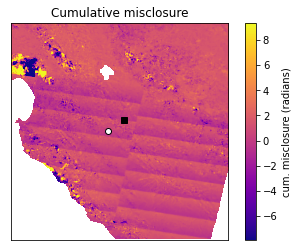

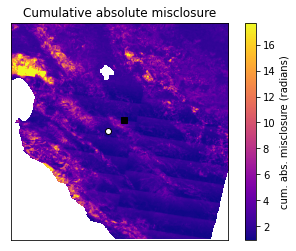

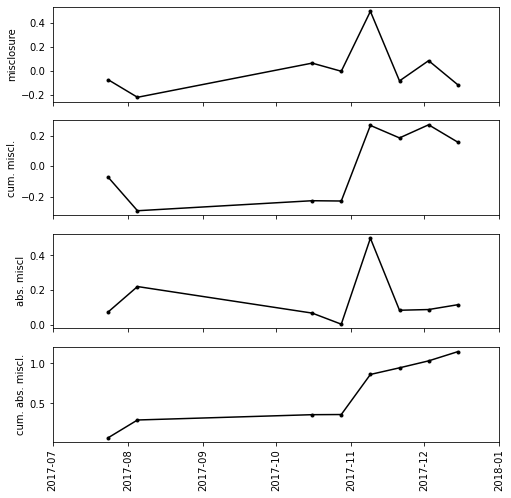

In [12]:
## Visualize misclosure
dataStack.plotCumMisclosure(queryLoLa=[-121.11,36.51])

<div class="alert alert-warning">
<b>Note</b>, the time history of misclosure values are plotted as a function of the middle date of each triplet. If there is more than one triplet for each date, the time histories might be more difficult to interpret.
</div>

Using the command line tool, the use can click on different pixels of either the net misclosure or absolute misclosure maps to see the time history of any pixel. The pixel values are printed to the terminal.

Once the interactive plots are closed, the figures are saved to files.

The cumulative net and absolute misclosure figures are saved as georeferenced GeoTiffs for use with mapping software.